In [0]:
%tensorflow_version 2.x
from __future__ import absolute_import, division, print_function, unicode_literals

In [0]:
import tensorflow as tf

In [0]:
# tf.compat.v1.disable_eager_execution()

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers
import time
import os
import pandas as pd
from sklearn.model_selection import train_test_split


In [99]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Read train and test dataset, then shuffle it

In [0]:
SG_df = pd.read_csv("/content/drive/My Drive/Hackaton/sgcar_colapse.csv", parse_dates=['pingtimestamp', 'pickup_time', 'dropoff_time'])

In [101]:
SG_df

,Unnamed: 0,trj_id,osname,pingtimestamp,rawlat,rawlng,speed,bearing,accuracy,travel_time,pickup_time,dropoff_time,rawlat_pickup,rawlng_pickup,rawlat_dropoff,rawlng_dropoff,pickup_hour,pickup_day,sin_pickup_hour,cos_pickup_hour,sin_pickup_day,cos_pickup_day
0,0,2,android,2019-04-09 02:38:48,1.270377,103.857875,25.623161,100,32.000,1520.0,2019-04-09 02:38:48,2019-04-09 03:04:08,1.270377,103.857875,1.446609,103.806354,2,1,5.000000e-01,0.866025,0.781831,0.623490
1,1,3,ios,2019-04-12 08:32:16,1.282591,103.851082,0.000000,96,30.000,1158.0,2019-04-12 08:32:16,2019-04-12 08:51:34,1.282591,103.851082,1.332855,103.977278,8,4,8.660254e-01,-0.500000,-0.433884,-0.900969
2,2,4,android,2019-04-13 10:42:40,1.355363,103.863157,5.960000,217,3.900,1366.0,2019-04-13 10:42:40,2019-04-13 11:05:26,1.355363,103.863157,1.343218,103.858504,10,5,5.000000e-01,-0.866025,-0.974928,-0.222521
3,3,5,ios,2019-04-20 01:39:08,1.340301,103.775742,4.760463,91,6.000,1328.0,2019-04-20 01:39:08,2019-04-20 02:01:16,1.340301,103.775742,1.303071,103.900220,1,5,2.588190e-01,0.965926,-0.974928,-0.222521
4,4,8,android,2019-04-11 07:24:34,1.333936,103.953225,15.250000,318,4.288,1210.0,2019-04-11 07:24:34,2019-04-11 07:44:44,1.333936,103.953225,1.309601,103.833983,7,3,9.659258e-01,-0.258819,0.433884,-0.900969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,27995,83955,android,2019-04-08 22:27:51,1.396872,103.747718,11.609461,191,3.900,1112.0,2019-04-08 22:27:51,2019-04-08 22:46:23,1.396872,103.747718,1.319548,103.843496,22,0,-5.000000e-01,0.866025,0.000000,1.000000
27996,27996,83956,ios,2019-04-09 22:09:13,1.396533,103.747537,3.212061,196,6.000,983.0,2019-04-09 22:09:13,2019-04-09 22:25:36,1.396533,103.747537,1.322236,103.841737,22,1,-5.000000e-01,0.866025,0.781831,0.623490
27997,27997,83957,android,2019-04-21 01:20:41,1.301317,103.899443,11.049027,244,5.600,1382.0,2019-04-21 01:20:41,2019-04-21 01:43:43,1.301317,103.899443,1.410657,103.778843,1,6,2.588190e-01,0.965926,-0.781831,0.623490
27998,27998,83999,android,2019-04-17 11:22:25,1.298612,103.853801,0.000000,0,4.137,1212.0,2019-04-17 11:22:25,2019-04-17 11:42:37,1.298612,103.853801,1.341310,103.981728,11,2,2.588190e-01,-0.965926,0.974928,-0.222521


In [0]:
SG_df = SG_df.drop(columns=['Unnamed: 0', 'pingtimestamp', 'pickup_time', 'dropoff_time'])

In [103]:
SG_df

,trj_id,osname,rawlat,rawlng,speed,bearing,accuracy,travel_time,rawlat_pickup,rawlng_pickup,rawlat_dropoff,rawlng_dropoff,pickup_hour,pickup_day,sin_pickup_hour,cos_pickup_hour,sin_pickup_day,cos_pickup_day
0,2,android,1.270377,103.857875,25.623161,100,32.000,1520.0,1.270377,103.857875,1.446609,103.806354,2,1,5.000000e-01,0.866025,0.781831,0.623490
1,3,ios,1.282591,103.851082,0.000000,96,30.000,1158.0,1.282591,103.851082,1.332855,103.977278,8,4,8.660254e-01,-0.500000,-0.433884,-0.900969
2,4,android,1.355363,103.863157,5.960000,217,3.900,1366.0,1.355363,103.863157,1.343218,103.858504,10,5,5.000000e-01,-0.866025,-0.974928,-0.222521
3,5,ios,1.340301,103.775742,4.760463,91,6.000,1328.0,1.340301,103.775742,1.303071,103.900220,1,5,2.588190e-01,0.965926,-0.974928,-0.222521
4,8,android,1.333936,103.953225,15.250000,318,4.288,1210.0,1.333936,103.953225,1.309601,103.833983,7,3,9.659258e-01,-0.258819,0.433884,-0.900969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,83955,android,1.396872,103.747718,11.609461,191,3.900,1112.0,1.396872,103.747718,1.319548,103.843496,22,0,-5.000000e-01,0.866025,0.000000,1.000000
27996,83956,ios,1.396533,103.747537,3.212061,196,6.000,983.0,1.396533,103.747537,1.322236,103.841737,22,1,-5.000000e-01,0.866025,0.781831,0.623490
27997,83957,android,1.301317,103.899443,11.049027,244,5.600,1382.0,1.301317,103.899443,1.410657,103.778843,1,6,2.588190e-01,0.965926,-0.781831,0.623490
27998,83999,android,1.298612,103.853801,0.000000,0,4.137,1212.0,1.298612,103.853801,1.341310,103.981728,11,2,2.588190e-01,-0.965926,0.974928,-0.222521


In [104]:
def train_test_split(df, percent_split):
  """split the df into train and test dataframe with
  the number of data in train and test will be equals to:
  train_df: df[:int(n*percent_split)]
  test_df: df[int(percent_split*n):]

  Parameters
    df [pandas DataFrame] -- the dataset that we want to split
    percent_split [int in range [0,1]] -- percentage of data we want to use for training
  """
  df = df.reindex(np.random.permutation(df.index)) # shuffle the examples
  split = int(len(df) * percent_split)
  train_df = df[:split]
  test_df = df[split:]
  return train_df, test_df

percent_split = 0.855
train_df, test_df = train_test_split(SG_df, percent_split)
print(len(train_df))
print(len(test_df))

23940
4060


In [105]:

# train_df
test_df

,trj_id,osname,rawlat,rawlng,speed,bearing,accuracy,travel_time,rawlat_pickup,rawlng_pickup,rawlat_dropoff,rawlng_dropoff,pickup_hour,pickup_day,sin_pickup_hour,cos_pickup_hour,sin_pickup_day,cos_pickup_day
6138,28455,android,1.315275,103.864393,8.379547,312,8.000,1541.0,1.315275,103.864393,1.341218,103.690223,22,6,-0.500000,0.866025,-0.781831,0.623490
18061,66637,ios,1.323760,103.890896,6.350000,182,10.000,1049.0,1.323760,103.890896,1.350128,103.728218,13,2,-0.258819,-0.965926,0.974928,-0.222521
18605,67504,android,1.359689,103.960399,11.700000,38,4.288,1326.0,1.359689,103.960399,1.364060,103.843334,1,1,0.258819,0.965926,0.781831,0.623490
15869,62852,android,1.330295,103.921639,15.541878,305,4.000,1149.0,1.330295,103.921639,1.410009,103.807412,1,5,0.258819,0.965926,-0.974928,-0.222521
23004,74342,ios,1.340873,103.848073,8.811524,92,7.000,1257.0,1.340873,103.848073,1.434456,103.833904,8,4,0.866025,-0.500000,-0.433884,-0.900969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17571,65781,android,1.273558,103.846457,7.540000,222,6.000,1186.0,1.273558,103.846457,1.352904,103.728967,9,2,0.707107,-0.707107,0.974928,-0.222521
10244,44581,ios,1.356053,103.959979,3.560173,332,6.000,958.0,1.356053,103.959979,1.334938,103.888522,4,1,0.866025,0.500000,0.781831,0.623490
19551,68921,android,1.344432,103.983258,12.990045,203,3.900,1154.0,1.344432,103.983258,1.343443,103.853007,15,1,-0.707107,-0.707107,0.781831,0.623490
19162,68314,ios,1.437661,103.808246,15.857105,221,8.000,939.0,1.437661,103.808246,1.336355,103.862371,4,2,0.866025,0.500000,0.974928,-0.222521


## Represent Data
we will do feature cross between rawlat and rawlon for pickup and dropoff

## Standardize latitude and longitude

In [0]:
# calculate Z-score of latitude and longitude for pickup and drop off (train_df)
train_df['rawlat_pickup'] = (train_df['rawlat_pickup'] - np.mean(train_df['rawlat_pickup'])) / np.std(train_df['rawlat_pickup'])
train_df['rawlat_dropoff'] = (train_df['rawlat_dropoff'] - np.mean(train_df['rawlat_dropoff'])) / np.std(train_df['rawlat_dropoff'])

train_df['rawlng_pickup'] = (train_df['rawlng_pickup'] - np.mean(train_df['rawlng_pickup'])) / np.std(train_df['rawlng_pickup'])
train_df['rawlng_dropoff'] = (train_df['rawlng_dropoff'] - np.mean(train_df['rawlng_dropoff'])) / np.std(train_df['rawlng_dropoff'])

# calculate Z-score of latitude and longitude for pickup and drop off (test_df)
test_df['rawlat_pickup'] = (test_df['rawlat_pickup'] - np.mean(test_df['rawlat_pickup'])) / np.std(test_df['rawlat_pickup'])
test_df['rawlat_dropoff'] = (test_df['rawlat_dropoff'] - np.mean(test_df['rawlat_dropoff'])) / np.std(test_df['rawlat_dropoff'])

test_df['rawlng_pickup'] = (test_df['rawlng_pickup'] - np.mean(test_df['rawlng_pickup'])) / np.std(test_df['rawlng_pickup'])
test_df['rawlng_dropoff'] = (test_df['rawlng_dropoff'] - np.mean(test_df['rawlng_dropoff'])) / np.std(test_df['rawlng_dropoff'])

In [107]:
train_df

,trj_id,osname,rawlat,rawlng,speed,bearing,accuracy,travel_time,rawlat_pickup,rawlng_pickup,rawlat_dropoff,rawlng_dropoff,pickup_hour,pickup_day,sin_pickup_hour,cos_pickup_hour,sin_pickup_day,cos_pickup_day
3244,13668,android,1.422424,103.825204,18.363756,189,4.000,955.0,1.539798,-0.161574,-0.553905,0.219607,3,3,0.707107,7.071068e-01,0.433884,-0.900969
19441,68724,ios,1.331688,103.757481,4.407542,123,12.000,1252.0,-0.398172,-1.020783,-0.828471,-0.100300,10,0,0.500000,-8.660254e-01,0.000000,1.000000
5436,25821,ios,1.292295,103.798019,13.120000,59,5.000,872.0,-1.239551,-0.506468,0.579566,0.255204,6,3,1.000000,6.123234e-17,0.433884,-0.900969
4290,20664,ios,1.301682,103.862715,2.155108,180,32.000,1836.0,-1.039051,0.314329,2.122613,-0.099715,16,6,-0.866025,-5.000000e-01,-0.781831,0.623490
5098,24593,ios,1.349132,103.719872,2.410000,180,10.000,908.0,-0.025584,-1.497931,-1.416218,-0.074606,14,1,-0.500000,-8.660254e-01,0.781831,0.623490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8128,35611,android,1.395218,103.869614,17.650000,275,3.900,1807.0,0.958731,0.401868,1.922950,-0.755126,11,4,0.258819,-9.659258e-01,-0.433884,-0.900969
13734,59531,android,1.348772,103.710992,0.000000,50,3.000,1854.0,-0.033273,-1.610593,0.231299,1.223466,7,6,0.965926,-2.588190e-01,-0.781831,0.623490
23465,75119,android,1.337870,103.915932,0.000000,75,3.099,1424.0,-0.266143,0.989500,-0.090226,-1.430431,6,0,1.000000,6.123234e-17,0.000000,1.000000
14613,60594,ios,1.303798,103.906179,1.031370,37,13.000,1326.0,-0.993850,0.865766,0.608583,1.443750,10,3,0.500000,-8.660254e-01,0.433884,-0.900969


## Create a features column for training
since we already normalized the latitude and longitude into Z-score, we will need to divide the latitude and longitude into bucket of bins with its resolution in Z(think of resolution in Z in similar way of Depth Per Inch in a screen-which is how many numper of pixel contains in an inch). the higher resolution in Z will contain more latitude and longitude per bins.

In [0]:
# Create an empty list that will eventually hold all created feature columns.
feature_columns = []

# resolution_in_Zs of 1 corresponds to 
# a full standard deviation. 
resolution_in_Zs = 0.2  # 2/10 of a standard deviation.

# Create a bucket feature column for latitude.
pickup_latitude_as_a_numeric_column = tf.feature_column.numeric_column("rawlat_pickup")
pickup_latitude_boundaries = list(np.arange(int(min(train_df['rawlat_pickup'])), 
                                     int(max(train_df['rawlat_pickup'])), 
                                     resolution_in_Zs))
pickup_latitude = tf.feature_column.bucketized_column(pickup_latitude_as_a_numeric_column, pickup_latitude_boundaries)

# drop off latitude
dropoff_latitude_as_a_numeric_column = tf.feature_column.numeric_column("rawlat_dropoff")
dropoff_latitude_boundaries = list(np.arange(int(min(train_df['rawlat_dropoff'])), 
                                     int(max(train_df['rawlat_dropoff'])), 
                                     resolution_in_Zs))
dropoff_latitude = tf.feature_column.bucketized_column(dropoff_latitude_as_a_numeric_column, dropoff_latitude_boundaries)

# Create a bucket feature column for longitude.
pickup_longitude_as_a_numeric_column = tf.feature_column.numeric_column("rawlng_pickup")
pickup_longitude_boundaries = list(np.arange(int(min(train_df['rawlng_pickup'])), 
                                     int(max(train_df['rawlng_pickup'])), 
                                     resolution_in_Zs))
pickup_longitude = tf.feature_column.bucketized_column(pickup_longitude_as_a_numeric_column, pickup_longitude_boundaries)


dropoff_longitude_as_a_numeric_column = tf.feature_column.numeric_column("rawlng_dropoff")
dropoff_longitude_boundaries = list(np.arange(int(min(train_df['rawlng_dropoff'])), 
                                      int(max(train_df['rawlng_dropoff'])), 
                                      resolution_in_Zs))
dropoff_longitude = tf.feature_column.bucketized_column(dropoff_longitude_as_a_numeric_column, 
                                                dropoff_longitude_boundaries)

# Create a feature cross of latitude and longitude.
pickup_latitude_x_pickup_longitude = tf.feature_column.crossed_column([pickup_latitude, pickup_longitude], hash_bucket_size=150)
crossed_pickup_feature = tf.feature_column.indicator_column(pickup_latitude_x_pickup_longitude)
feature_columns.append(crossed_pickup_feature)  

# cross dropoff feature
dropoff_latitude_x_dropoff_longitude = tf.feature_column.crossed_column([dropoff_latitude, dropoff_longitude], hash_bucket_size=150)
crossed_dropoff_feature = tf.feature_column.indicator_column(dropoff_latitude_x_dropoff_longitude)
feature_columns.append(crossed_dropoff_feature) 



In [109]:
feature_columns

[IndicatorColumn(categorical_column=CrossedColumn(keys=(BucketizedColumn(source_column=NumericColumn(key='rawlat_pickup', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(-2.0, -1.8, -1.6, -1.4000000000000001, -1.2000000000000002, -1.0000000000000002, -0.8000000000000003, -0.6000000000000003, -0.40000000000000036, -0.2000000000000004, -4.440892098500626e-16, 0.1999999999999993, 0.39999999999999947, 0.5999999999999996, 0.7999999999999994, 0.9999999999999991, 1.1999999999999993, 1.3999999999999995, 1.5999999999999992, 1.799999999999999)), BucketizedColumn(source_column=NumericColumn(key='rawlng_pickup', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(-2.0, -1.8, -1.6, -1.4000000000000001, -1.2000000000000002, -1.0000000000000002, -0.8000000000000003, -0.6000000000000003, -0.40000000000000036, -0.2000000000000004, -4.440892098500626e-16, 0.1999999999999993, 0.39999999999999947, 0.5999999999999996, 0.7999999999999994, 0.9

In [0]:
# Create numeric column for time in day and hour.

# Represent sin and cos of hour as a floating-point value.
sin_pickup_hour = tf.feature_column.numeric_column("sin_pickup_hour")
feature_columns.append(sin_pickup_hour)

cos_pickup_hour = tf.feature_column.numeric_column("cos_pickup_hour")
feature_columns.append(cos_pickup_hour)

# Represent sin and cos of day as a floating-point value.
sin_pickup_day = tf.feature_column.numeric_column("sin_pickup_day")
feature_columns.append(sin_pickup_day)

cos_pickup_day = tf.feature_column.numeric_column("cos_pickup_day")
feature_columns.append(cos_pickup_day)

# Convert the list of feature columns into a layer that will later be fed into
# the model. 
my_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

# Build Densenet baseline model

## Define plotting function

In [0]:
def plot_loss_curve(epochs, rmse):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Root Mean Squared Error")

  plt.plot(epochs, rmse, label="Loss")
  plt.legend()
  plt.ylim([rmse.min()*0.95, rmse.max() * 1.03])
  plt.show()  


## Create our densenet model

In [0]:
def create_model(feature_layer, learning_rate=0.00001):
  leaky_relu_alpha = 0.1
  model = tf.keras.models.Sequential()

  # Add layer containing the feature columns to the layer
  model.add(feature_layer)

  # Define first hidden layer with 500 node
  model.add(tf.keras.layers.Dense(units=500,
                                  name='Hidden1'))
  # Define leaky relu activation layer
  model.add(tf.keras.layers.LeakyReLU(alpha=leaky_relu_alpha))

  # Define second hidden layer with 300 node
  model.add(tf.keras.layers.Dense(units=300, 
                                  name='Hidden2'))
  
  # Define leaky relu activation layer
  model.add(tf.keras.layers.LeakyReLU(alpha=leaky_relu_alpha))

  # Define third hidden layer with 50 node
  model.add(tf.keras.layers.Dense(units=50,
                                  name='Hidden3'))
  
  # Define leaky relu activation layer
  model.add(tf.keras.layers.LeakyReLU(alpha=leaky_relu_alpha))

  # Define fourth hidden layer with 50 node
  model.add(tf.keras.layers.Dense(units=50,
                                  name='Hidden4'))
  
  # Define leaky relu activation layer
  model.add(tf.keras.layers.LeakyReLU(alpha=leaky_relu_alpha))

  # Define fifth hidden layer with 50 node
  model.add(tf.keras.layers.Dense(units=50,
                                  name='Hidden4'))
  
  # Define leaky relu activation layer
  model.add(tf.keras.layers.LeakyReLU(alpha=leaky_relu_alpha))

  # Define output layer
  model.add(tf.keras.layers.Dense(units=1,
                                  name='Output'))
  
  # Construct the layers into a model that TensorFlow can execute.
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.RootMeanSquaredError()])
  
  return model

## Define training function.

In [0]:
def train_model(model, dataset, epochs, train_label,
                batch_size, validation_split=0.2):
  
  # Split the dataset into features and label.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name))

  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, validation_split=validation_split)
  
  # list of epochs of the model
  epochs = history.epoch

  #gather snapshot of the model's mean squared error
  # at each epoch.
  hist = pd.DataFrame(history.history)
  rmse = hist["root_mean_squared_error"]

  return epochs, rmse

# Train Densenet model

Epoch 1/25
192/192 [==============================] - 1s 6ms/step - loss: 177408.5000 - root_mean_squared_error: 421.1989 - val_loss: 85405.1484 - val_root_mean_squared_error: 292.2416
Epoch 2/25
192/192 [==============================] - 1s 5ms/step - loss: 93187.5078 - root_mean_squared_error: 305.2663 - val_loss: 84961.4766 - val_root_mean_squared_error: 291.4815
Epoch 3/25
192/192 [==============================] - 1s 5ms/step - loss: 94284.9766 - root_mean_squared_error: 307.0586 - val_loss: 90161.4375 - val_root_mean_squared_error: 300.2690
Epoch 4/25
192/192 [==============================] - 1s 5ms/step - loss: 89542.2812 - root_mean_squared_error: 299.2362 - val_loss: 86772.5156 - val_root_mean_squared_error: 294.5717
Epoch 5/25
192/192 [==============================] - 1s 5ms/step - loss: 91064.2969 - root_mean_squared_error: 301.7686 - val_loss: 84233.9297 - val_root_mean_squared_error: 290.2308
Epoch 6/25
192/192 [==============================] - 1s 5ms/step - loss: 85704

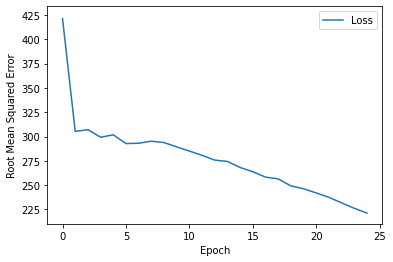

In [127]:
batch_size = 100
epochs = 25
learning_rate = 0.01

# Specify the label
label_name = "travel_time"

# Establish model's topography
my_model = create_model(my_feature_layer, learning_rate)

# Train the model on normalized training set
epochs, rmse = train_model(my_model, train_df, epochs, label_name,
                batch_size)

# plot RMSE curve
plot_loss_curve(epochs, rmse)


In [128]:
# After building a model against the training set, test that model
# against the test set.
test_features = {name:np.array(value) for name, value in test_df.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)


 Evaluate the new model against the test set:
41/41 [==============================] - 0s 4ms/step - loss: 164145.9219 - root_mean_squared_error: 405.1493


[164145.921875, 405.1492614746094]